In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import tensorflow as tf
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
from imblearn.over_sampling import SMOTE
# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
import pickle
import warnings
warnings.filterwarnings("ignore")
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, RobustScaler
from mpl_toolkits.mplot3d import Axes3D

In [38]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [3]:
df=pd.read_csv("final_list.csv")

In [4]:
df.head()

Unnamed: 0  YEAR    T2M  T2MDEW  T2MWET  QV2M   RH2M  PRECTOTCORR     PS  \
0           0  2001  13.83   10.39   12.12  7.87  79.56         0.13  99.87   
1           1  2001  13.73   10.64   12.19  8.00  81.44         0.12  99.83   
2           2  2001  13.55   10.83   12.19  8.12  83.50         0.22  99.82   
3           3  2001  13.37   10.97   12.17  8.18  85.19         0.10  99.80   
4           4  2001  13.27   11.10   12.19  8.24  86.50         0.04  99.82   

   WS10M   WD10M  WS50M   WD50M Location            timestamp  lightning  \
0   2.82   96.83   5.23   96.43    Banda  2001-01-01 00:00:00          0   
1   2.64  107.90   4.69  107.05    Banda  2001-01-01 01:00:00          0   
2   2.72  119.81   4.66  118.97    Banda  2001-01-01 02:00:00          0   
3   3.02  129.96   4.91  129.44    Banda  2001-01-01 03:00:00          0   
4   3.09  139.82   4.91  139.45    Banda  2001-01-01 04:00:00          0   

   year  month          day  
0  2001      1  01 00:00:00  
1  2001      1  01 01:00:00  
2  2001      1  01 02:00:00  
3  2001      1  01 03:00:00  
4  2001      1  01 04:00:00

In [5]:
df.isnull().sum()

Unnamed: 0     0
YEAR           0
T2M            0
T2MDEW         0
T2MWET         0
QV2M           0
RH2M           0
PRECTOTCORR    0
PS             0
WS10M          0
WD10M          0
WS50M          0
WD50M          0
Location       0
timestamp      0
lightning      0
year           0
month          0
day            0
dtype: int64

In [6]:
# The classes are heavily skewed we need to solve this issue later.
print('No Lightning', round(df['lightning'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Lightning', round(df['lightning'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Lightning 99.97 % of the dataset
Lightning 0.03 % of the dataset


Distribution of the Classes in the subsample dataset
0    0.999725
1    0.000275
Name: lightning, dtype: float64


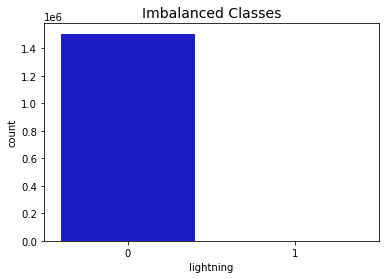

In [7]:
print('Distribution of the Classes in the subsample dataset')
print(df['lightning'].value_counts() / len(df))
colors = ["#0101DF", "#DF0101"]

sns.countplot(x='lightning', data=df, palette=colors)
plt.title('Imbalanced Classes', fontsize=14)
plt.show()

In [8]:
df['lightning'].value_counts()[1]

414

In [9]:
df['lightning'].value_counts()[0]

1506690

In [10]:
df.drop(['timestamp','day','year','Location','Unnamed: 0','YEAR','month'], axis=1, inplace=True)

In [11]:
df

T2M  T2MDEW  T2MWET  QV2M   RH2M  PRECTOTCORR     PS  WS10M  \
0        13.83   10.39   12.12  7.87  79.56         0.13  99.87   2.82   
1        13.73   10.64   12.19  8.00  81.44         0.12  99.83   2.64   
2        13.55   10.83   12.19  8.12  83.50         0.22  99.82   2.72   
3        13.37   10.97   12.17  8.18  85.19         0.10  99.80   3.02   
4        13.27   11.10   12.19  8.24  86.50         0.04  99.82   3.09   
...        ...     ...     ...   ...    ...          ...    ...    ...   
1507099  32.20   13.58   22.89  9.83  32.38         0.00  99.16   2.99   
1507100  31.45   12.86   22.15  9.34  32.19         0.00  99.21   3.46   
1507101  30.86   12.39   21.62  9.09  32.25         0.00  99.21   4.07   
1507102  30.27   11.98   21.12  8.85  32.44         0.00  99.18   4.61   
1507103  29.55   11.64   20.60  8.61  33.06         0.00  99.13   4.85   

          WD10M  WS50M   WD50M  lightning  
0         96.83   5.23   96.43          0  
1        107.90   4.69  107.05          0  
2        119.81   4.66  118.97          0  
3        129.96   4.91  129.44          0  
4        139.82   4.91  139.45          0  
...         ...    ...     ...        ...  
1507099  109.71   5.85  110.01          0  
1507100  111.34   7.34  111.54          0  
1507101  112.72   8.37  112.78          0  
1507102  114.44   8.94  114.48          0  
1507103  116.81   9.06  116.85          0  

[1507104 rows x 12 columns]

In [12]:

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['sc_RH2M'] = rob_scaler.fit_transform(df['RH2M'].values.reshape(-1,1))
df['sc_QV2M'] = rob_scaler.fit_transform(df['QV2M'].values.reshape(-1,1))
df['sc_PRECTOTCORR'] = rob_scaler.fit_transform(df['PRECTOTCORR'].values.reshape(-1,1))
df['sc_T2M'] = rob_scaler.fit_transform(df['T2M'].values.reshape(-1,1))
df['sc_T2MDEW'] = rob_scaler.fit_transform(df['T2MDEW'].values.reshape(-1,1))
df['sc_T2MWET'] = rob_scaler.fit_transform(df['T2MWET'].values.reshape(-1,1))
df['sc_PS'] = rob_scaler.fit_transform(df['PS'].values.reshape(-1,1))
df['sc_WS10M'] = rob_scaler.fit_transform(df['WS10M'].values.reshape(-1,1))
df['sc_WD10M'] = rob_scaler.fit_transform(df['WD10M'].values.reshape(-1,1))
df['sc_WS50M'] = rob_scaler.fit_transform(df['WS50M'].values.reshape(-1,1))
df['sc_WD50M'] = rob_scaler.fit_transform(df['WD50M'].values.reshape(-1,1))
df.drop(['RH2M','QV2M','PRECTOTCORR', 'T2M','T2MDEW','T2MWET','PS','WS10M','WD10M','WS50M','WD50M'], axis=1, inplace=True)

In [13]:
corr=df.select_dtypes(include=["int64","float64"])
corr=corr.corr()["lightning"][:-1]
corr.sort_values(ascending=False)

lightning         1.000000
sc_T2M            0.016072
sc_T2MWET         0.014143
sc_PRECTOTCORR    0.010481
sc_T2MDEW         0.007289
sc_QV2M           0.005776
sc_WS10M          0.004454
sc_WS50M         -0.001047
sc_WD10M         -0.001804
sc_RH2M          -0.004721
sc_PS            -0.005112
Name: lightning, dtype: float64

In [14]:
df.head()

lightning   sc_RH2M   sc_QV2M  sc_PRECTOTCORR    sc_T2M  sc_T2MDEW  \
0          0  0.627724 -0.060606            13.0 -1.156584  -0.068220   
1          0  0.666736 -0.049959            12.0 -1.165480  -0.054354   
2          0  0.709483 -0.040131            22.0 -1.181495  -0.043816   
3          0  0.744553 -0.035217            10.0 -1.197509  -0.036051   
4          0  0.771737 -0.030303             4.0 -1.206406  -0.028841   

   sc_T2MWET     sc_PS  sc_WS10M  sc_WD10M  sc_WS50M  sc_WD50M  
0  -0.638332  0.568047  0.046243 -0.727040  0.314103 -0.738600  
1  -0.632719  0.544379 -0.057803 -0.671484  0.141026 -0.685028  
2  -0.632719  0.538462 -0.011561 -0.611713  0.131410 -0.624899  
3  -0.634322  0.526627  0.161850 -0.560775  0.211538 -0.572084  
4  -0.632719  0.538462  0.202312 -0.511292  0.211538 -0.521590

In [15]:
y= df['lightning']

In [16]:
X=df.drop(['lightning'],axis='columns')

In [17]:
smote=SMOTE(sampling_strategy='minority')

In [18]:
x_sm,y_sm=smote.fit_resample(X,y)

In [19]:
y_sm.value_counts()

0    1506690
1    1506690
Name: lightning, dtype: int64

In [20]:
new_df=pd.DataFrame(x_sm,y_sm)

In [21]:
new_df

sc_RH2M   sc_QV2M  sc_PRECTOTCORR    sc_T2M  sc_T2MDEW  sc_T2MWET  \
lightning                                                                       
0          0.627724 -0.060606            13.0 -1.156584  -0.068220  -0.638332   
0          0.627724 -0.060606            13.0 -1.156584  -0.068220  -0.638332   
0          0.627724 -0.060606            13.0 -1.156584  -0.068220  -0.638332   
0          0.627724 -0.060606            13.0 -1.156584  -0.068220  -0.638332   
0          0.627724 -0.060606            13.0 -1.156584  -0.068220  -0.638332   
...             ...       ...             ...       ...        ...        ...   
1          0.666736 -0.049959            12.0 -1.165480  -0.054354  -0.632719   
1          0.666736 -0.049959            12.0 -1.165480  -0.054354  -0.632719   
1          0.666736 -0.049959            12.0 -1.165480  -0.054354  -0.632719   
1          0.666736 -0.049959            12.0 -1.165480  -0.054354  -0.632719   
1          0.666736 -0.049959            12.0 -1.165480  -0.054354  -0.632719   

              sc_PS  sc_WS10M  sc_WD10M  sc_WS50M  sc_WD50M  
lightning                                                    
0          0.568047  0.046243 -0.727040  0.314103 -0.738600  
0          0.568047  0.046243 -0.727040  0.314103 -0.738600  
0          0.568047  0.046243 -0.727040  0.314103 -0.738600  
0          0.568047  0.046243 -0.727040  0.314103 -0.738600  
0          0.568047  0.046243 -0.727040  0.314103 -0.738600  
...             ...       ...       ...       ...       ...  
1          0.544379 -0.057803 -0.671484  0.141026 -0.685028  
1          0.544379 -0.057803 -0.671484  0.141026 -0.685028  
1          0.544379 -0.057803 -0.671484  0.141026 -0.685028  
1          0.544379 -0.057803 -0.671484  0.141026 -0.685028  
1          0.544379 -0.057803 -0.671484  0.141026 -0.685028  

[3013380 rows x 11 columns]

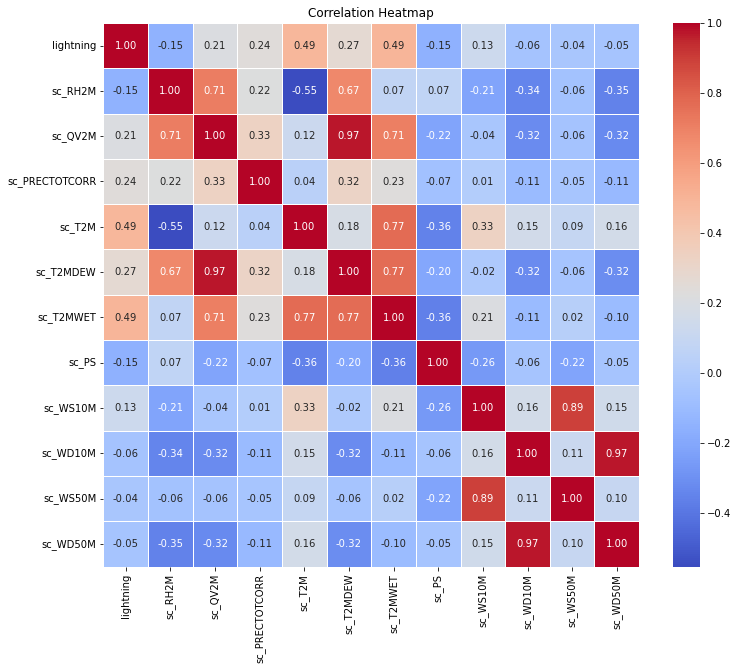

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Concatenate the target variable and features
df_concat = pd.concat([y_sm, x_sm], axis=1)

# Calculate the correlation matrix
correlation_matrix = df_concat.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [44]:
import plotly.express as px
import pandas as pd
import plotly.io as pio
# Concatenate the target variable and features
df_concat = pd.concat([y_sm, x_sm], axis=1)

# Calculate the correlation matrix
correlation_matrix = df_concat.corr()

# Create a heatmap with Plotly Express
fig_2d = px.imshow(
    correlation_matrix,
    labels=dict(color='Correlation'),
    x=correlation_matrix.columns,
    y=correlation_matrix.columns,
    color_continuous_scale='Viridis',  # Use a valid colorscale name
)

# Update layout for better visibility
fig_2d.update_layout(
    title='Correlation Heatmap',
    xaxis=dict(tickangle=-45),
    yaxis=dict(tickangle=45),
)

# Show the plot
fig_2d.show()


pio.write_html(fig_2d,file="2dheatmap.html",auto_open=True)

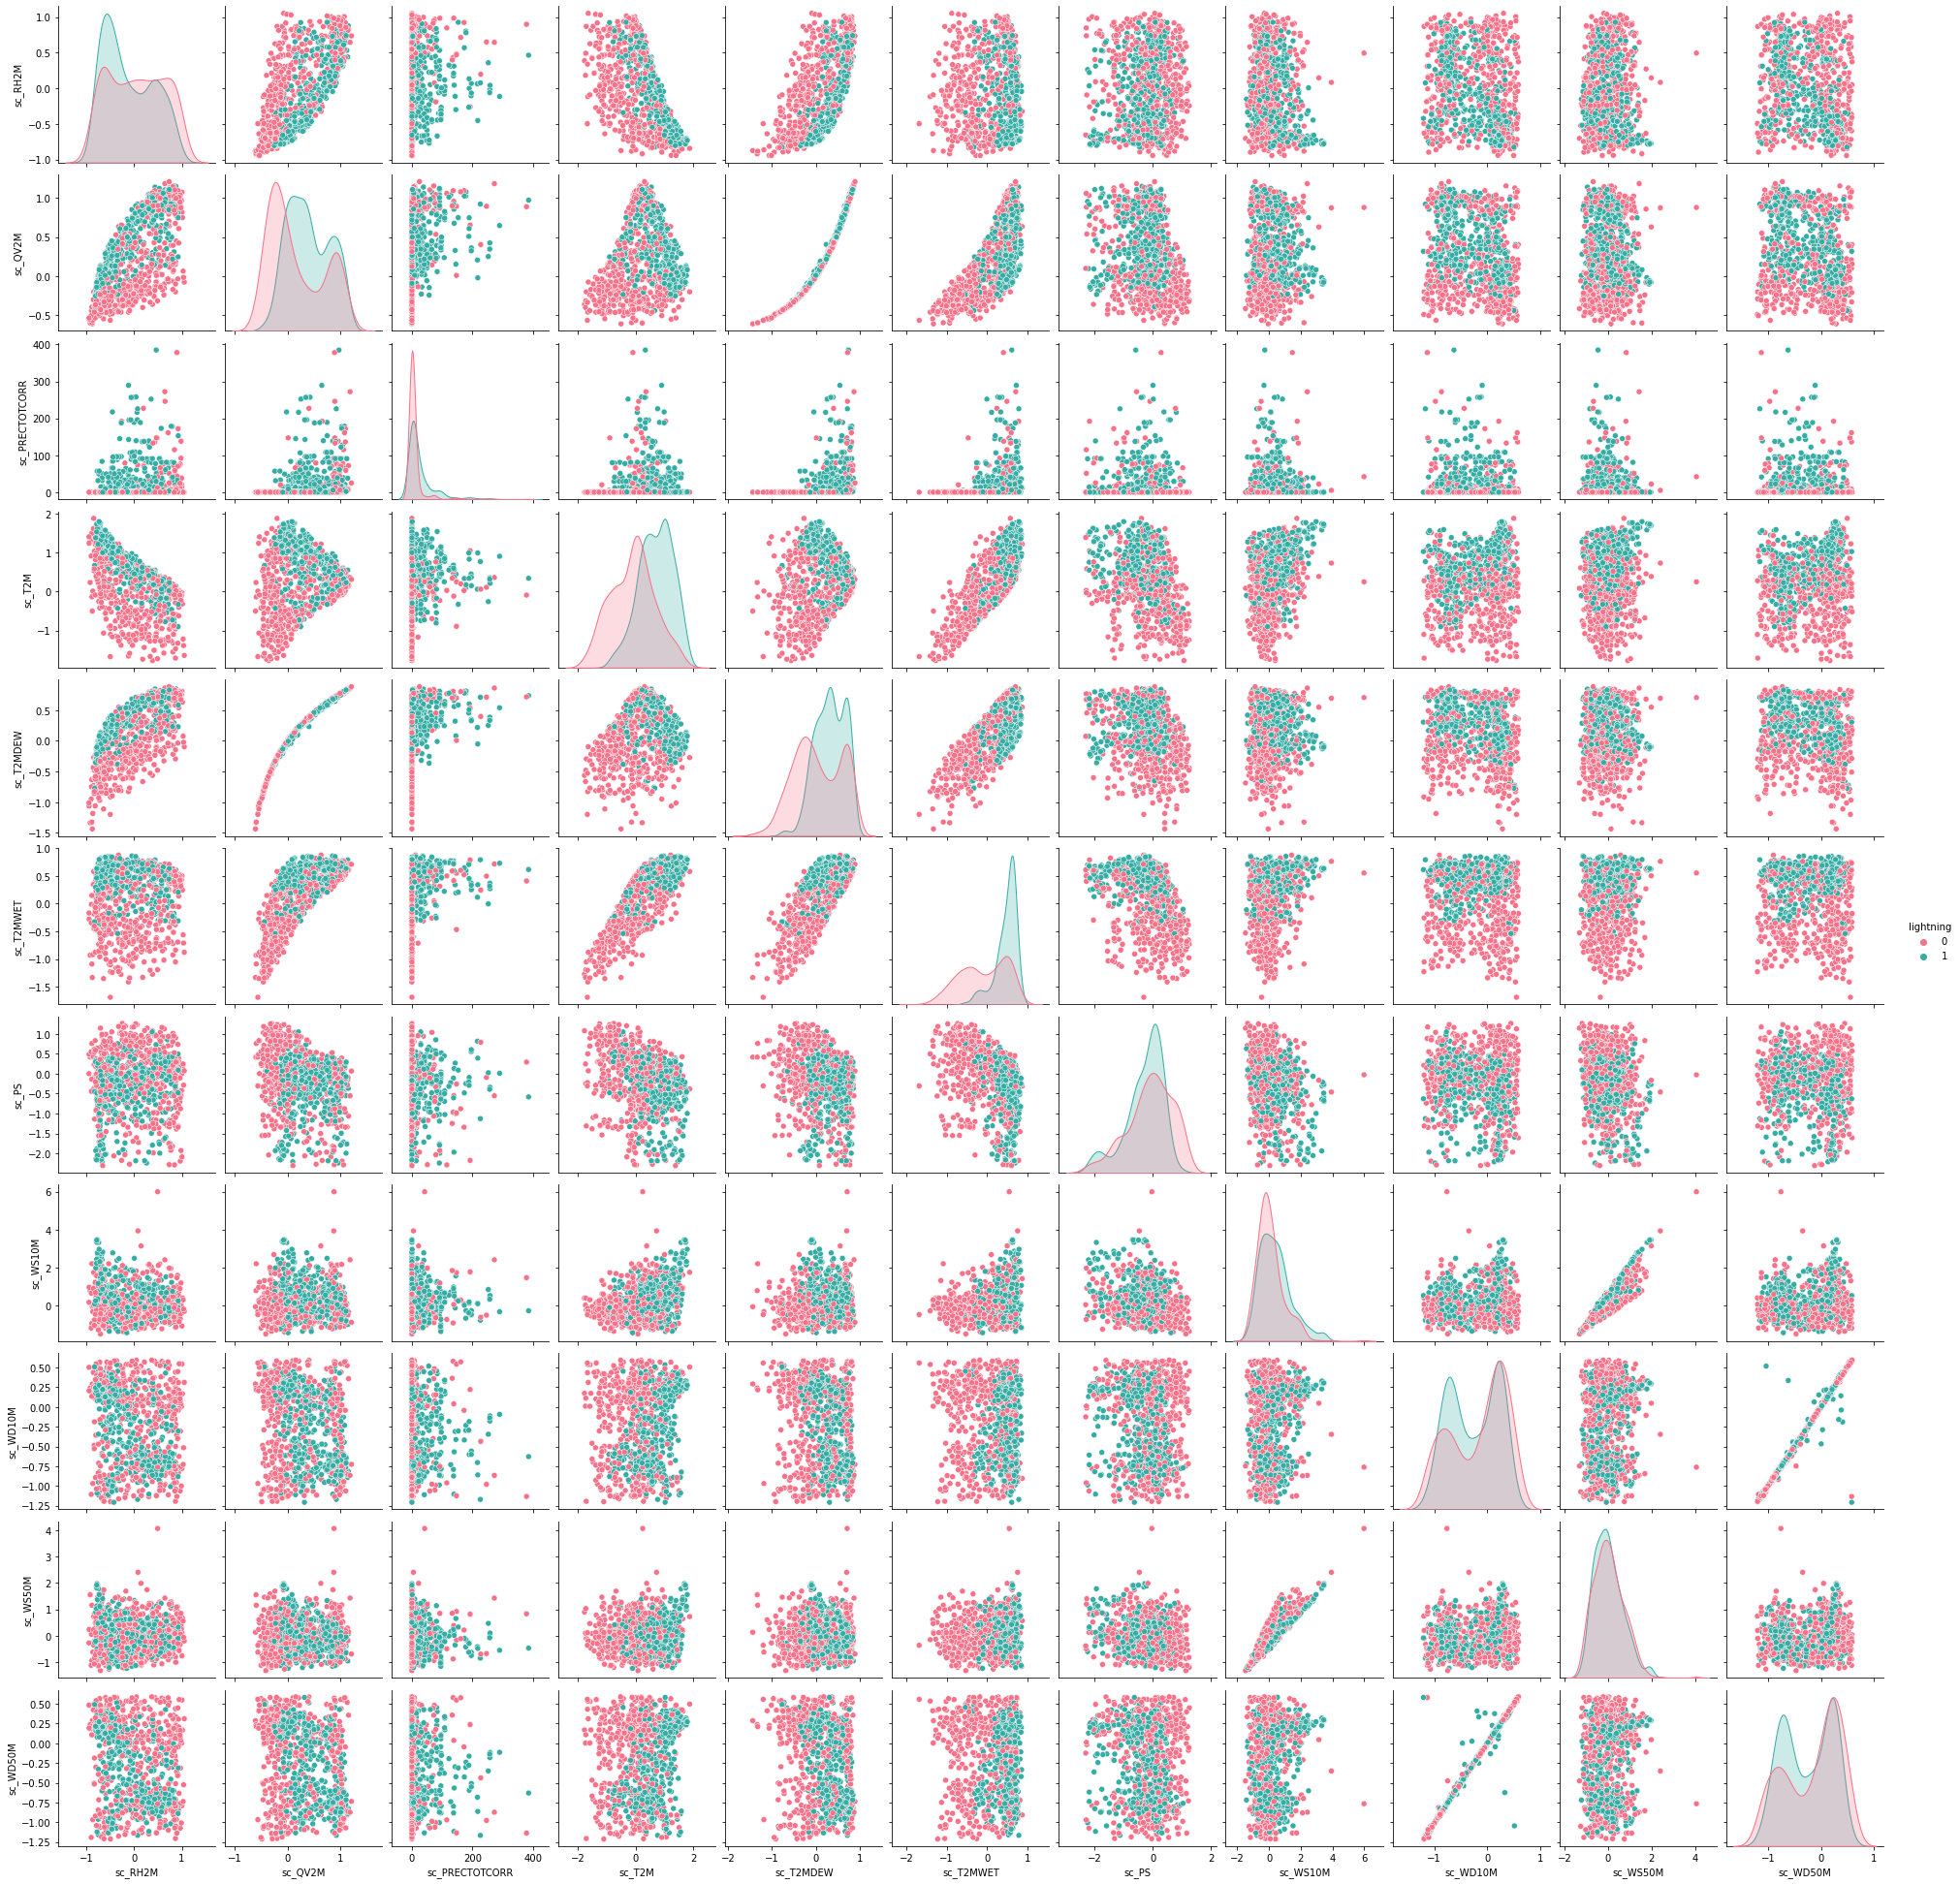

In [28]:
df_concat = pd.DataFrame(df_concat, columns=df_concat.columns)
sns.pairplot(df_concat.sample(n=1000, random_state=42), hue='lightning', palette='husl')
plt.show()

In [22]:
df_concat = pd.concat([y_sm, x_sm], axis=1)

In [23]:
df_concat.head()

lightning   sc_RH2M   sc_QV2M  sc_PRECTOTCORR    sc_T2M  sc_T2MDEW  \
0          0  0.627724 -0.060606            13.0 -1.156584  -0.068220   
1          0  0.666736 -0.049959            12.0 -1.165480  -0.054354   
2          0  0.709483 -0.040131            22.0 -1.181495  -0.043816   
3          0  0.744553 -0.035217            10.0 -1.197509  -0.036051   
4          0  0.771737 -0.030303             4.0 -1.206406  -0.028841   

   sc_T2MWET     sc_PS  sc_WS10M  sc_WD10M  sc_WS50M  sc_WD50M  
0  -0.638332  0.568047  0.046243 -0.727040  0.314103 -0.738600  
1  -0.632719  0.544379 -0.057803 -0.671484  0.141026 -0.685028  
2  -0.632719  0.538462 -0.011561 -0.611713  0.131410 -0.624899  
3  -0.634322  0.526627  0.161850 -0.560775  0.211538 -0.572084  
4  -0.632719  0.538462  0.202312 -0.511292  0.211538 -0.521590

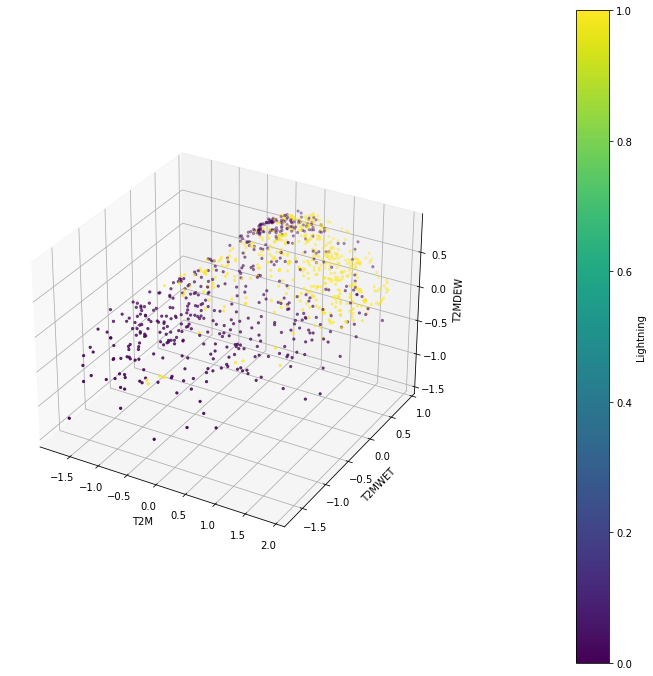

In [51]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Assuming df_concat contains your data
df_heatmap3d = df_concat.sample(n=1000, random_state=42)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with features on x, y, z and color based on target variable
sc = ax.scatter(
    df_heatmap3d['sc_T2M'],
    df_heatmap3d['sc_T2MWET'],
    df_heatmap3d['sc_T2MDEW'],
    c=df_heatmap3d['lightning'],
    cmap='viridis',
    marker='.'
)

# Set labels
ax.set_xlabel('T2M')
ax.set_ylabel('T2MWET')
ax.set_zlabel('T2MDEW')

# Add colorbar
cbar = fig.colorbar(sc, label='Lightning', pad=0.2)

# Show the plot
plt.show()

In [46]:
import plotly.express as px

# Assuming df_concat contains your data
df_heatmap3d = df_concat.sample(n=1000, random_state=42)

# Create a 3D scatter plot with Plotly
fig = px.scatter_3d(
    df_heatmap3d,
    x='sc_T2M',
    y='sc_T2MWET',
    z='sc_T2MDEW',
    color='lightning',
    labels={'sc_T2M': 'T2M', 'sc_T2MWET': 'T2MWET', 'sc_T2MDEW': 'T2MDEW'},
    color_continuous_scale='viridis',
    size_max=4  # Adjust this value to control the marker size
)

# Update layout to add colorbar
fig.update_layout(coloraxis_colorbar=dict(title='Lightning'), scene=dict(zaxis=dict(title='T2MDEW')))

# Show the plot
fig.show()
pio.write_html(fig,file="3dScatter.html",auto_open=True)

<Figure size 1080x1080 with 0 Axes>

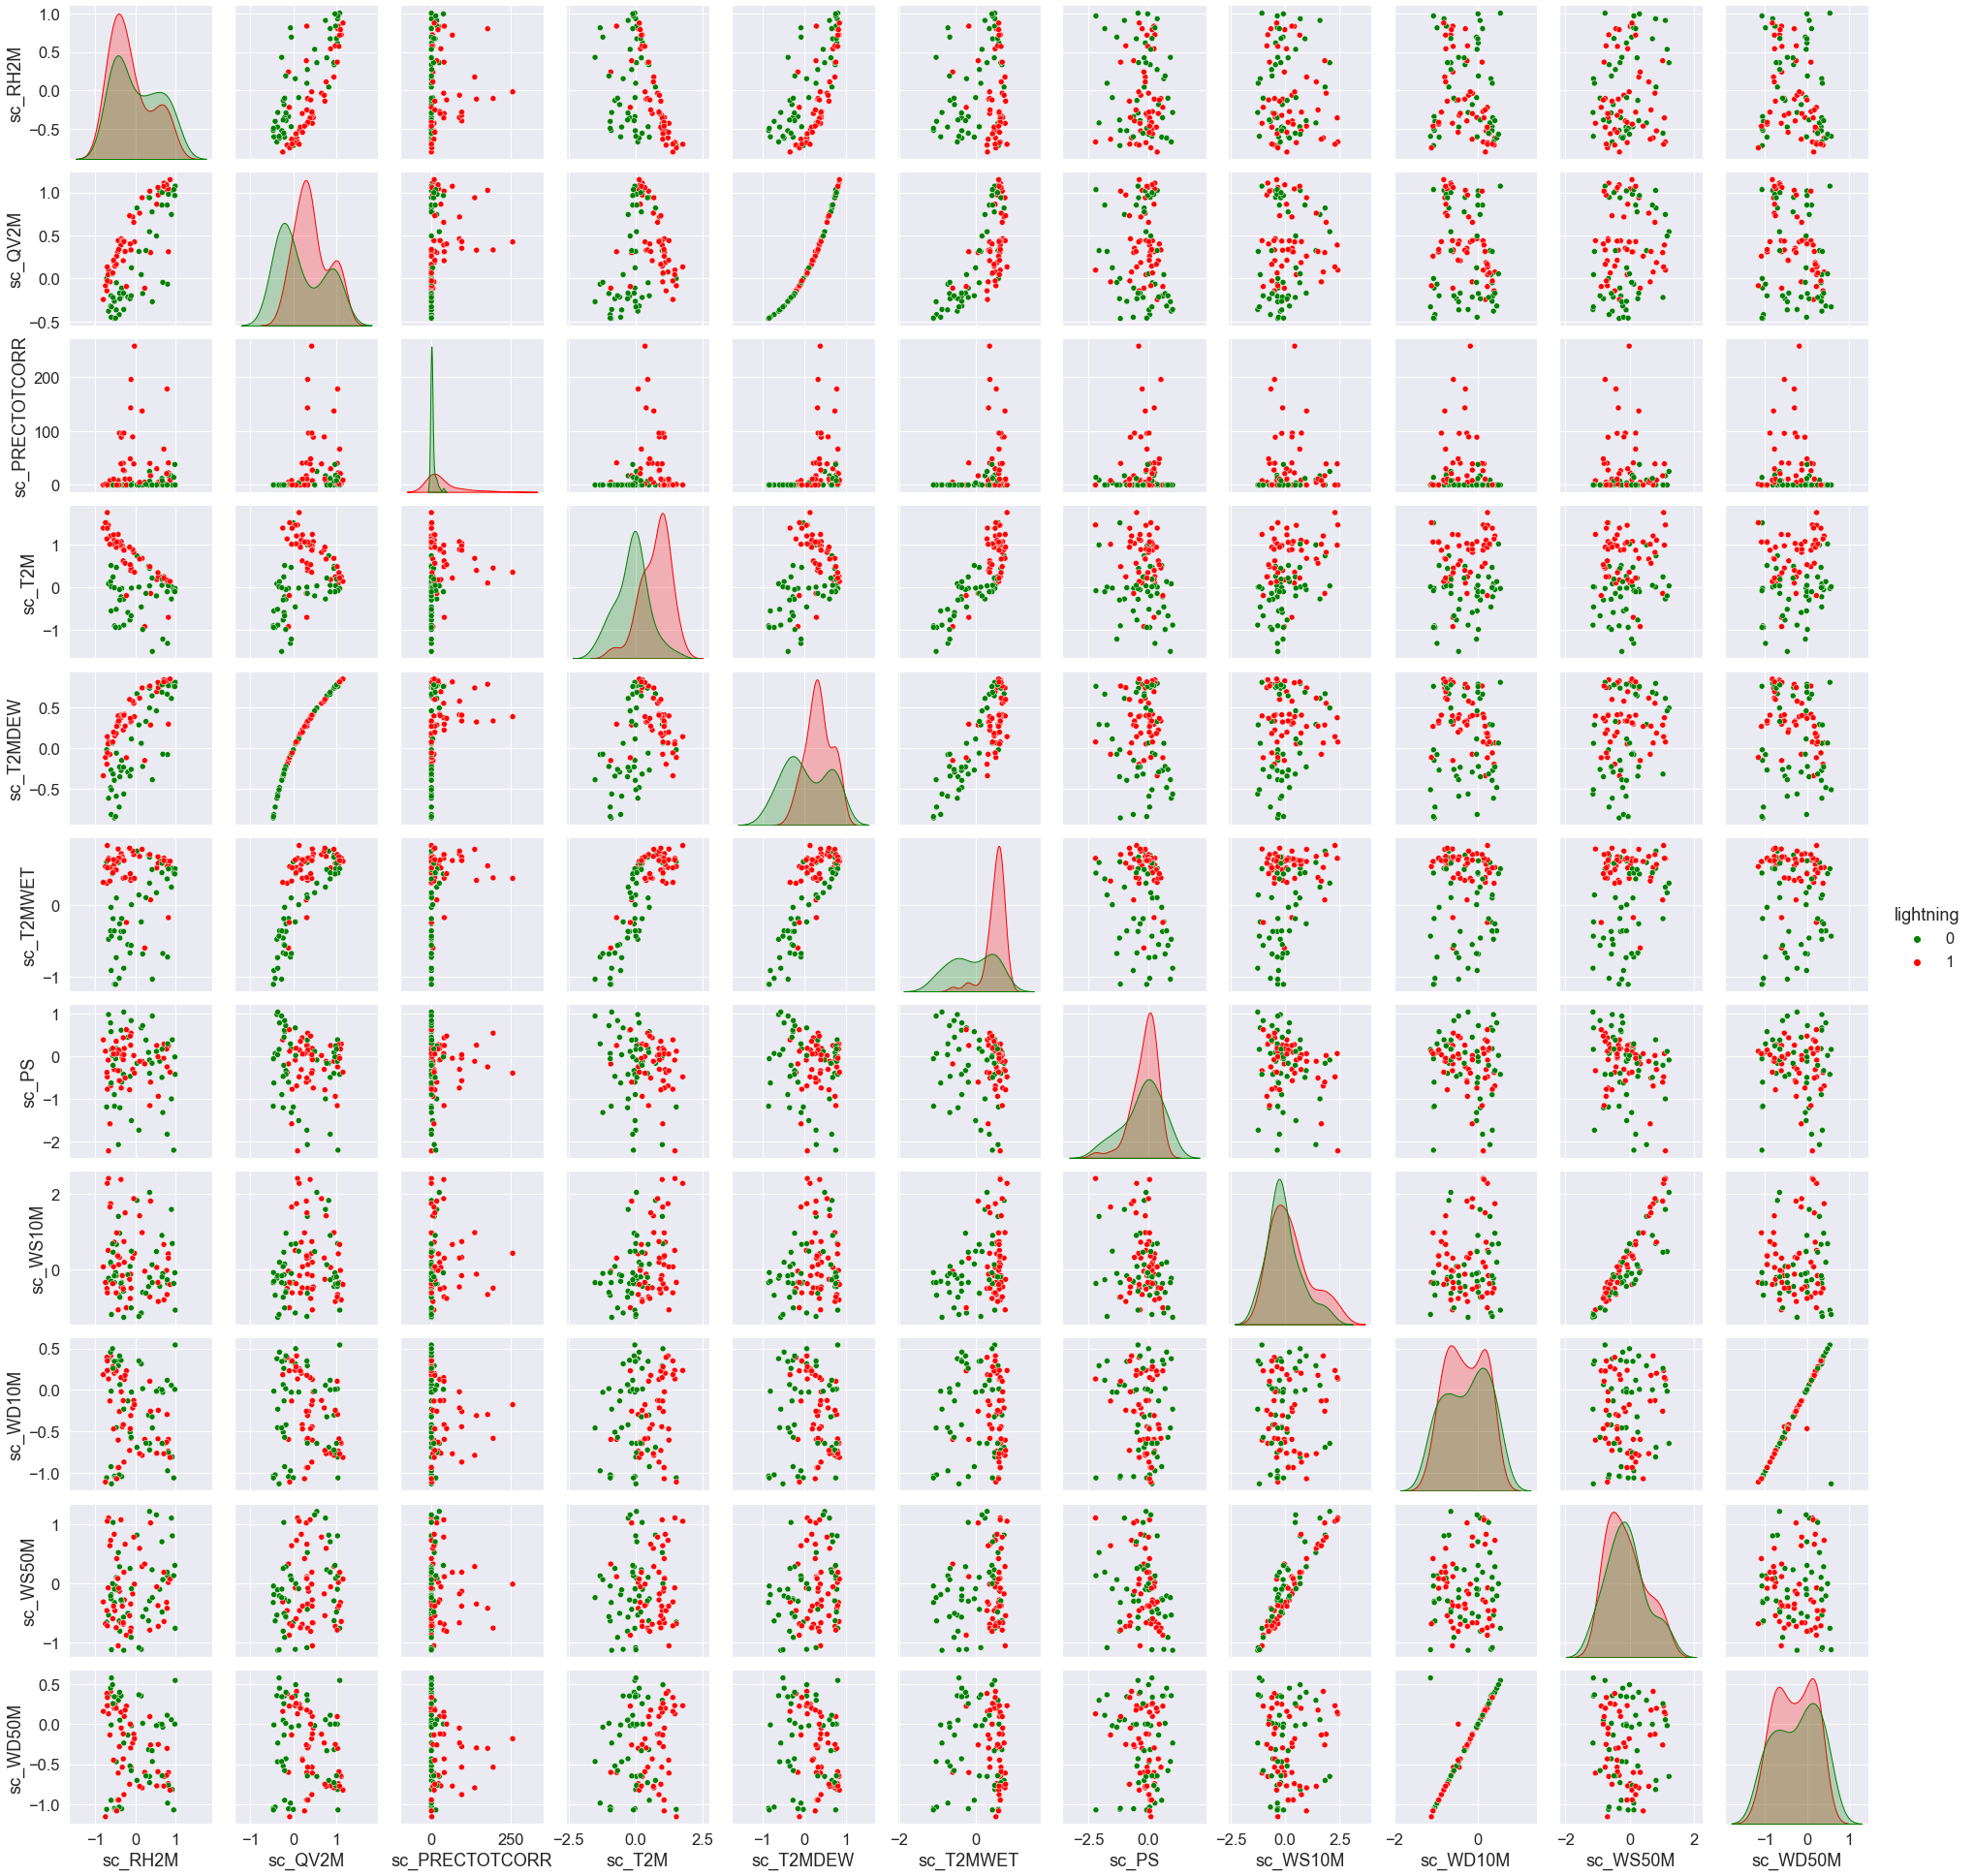

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_concat contains your data
df_heatmap3d = df_concat.sample(n=100, random_state=42)

# List of features
features = ['sc_RH2M', 'sc_QV2M', 'sc_PRECTOTCORR', 'sc_T2M', 'sc_T2MDEW', 'sc_T2MWET', 'sc_PS', 'sc_WS10M', 'sc_WD10M', 'sc_WS50M', 'sc_WD50M']

# Add the target variable to the dataframe for pairplot
df_heatmap3d_pairplot = pd.concat([df_heatmap3d['lightning'], df_heatmap3d[features]], axis=1)

# Set palette based on target variable values
palette = {0: 'green', 1: 'red'}  # Assuming binary values for 'lightning'

# Set font scale and plot size
sns.set(font_scale=1.5)
plt.figure(figsize=(15, 15))

# Create pairplot
sns.pairplot(df_heatmap3d_pairplot, hue='lightning', palette=palette, height=2.5)
plt.show()


In [22]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_sm,y_sm,test_size=0.2,random_state=15,stratify=y_sm)

In [54]:
#neural netwrok model


model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(11,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')  # Binary classification, so use sigmoid activation
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])  # Split a portion of the training data for validation

In [55]:
history = model.fit(x_train, y_train,
                    epochs=100)  # Split a portion of the training data for validation


Epoch 1/100
75335/75335 [==============================] - 76s 1000us/step - loss: 0.3144 - accuracy: 0.8694 - loss: 0.3146 - 
Epoch 2/100
75335/75335 [==============================] - 80s 1ms/step - loss: 0.2655 - accuracy: 0.8941
Epoch 3/100
75335/75335 [==============================] - 80s 1ms/step - loss: 0.2538 - accuracy: 0.8998
Epoch 4/100
75335/75335 [==============================] - 79s 1ms/step - loss: 0.2476 - accuracy: 0.9030
Epoch 5/100
75335/75335 [==============================] - 79s 1ms/step - loss: 0.2431 - accuracy: 0.9055
Epoch 6/100
75335/75335 [==============================] - 80s 1ms/step - loss: 0.2383 - accuracy: 0.9079
Epoch 7/100
75335/75335 [==============================] - 80s 1ms/step - loss: 0.2363 - accuracy: 0.9092
Epoch 8/100
75335/75335 [==============================] - 80s 1ms/step - loss: 0.2335 - accuracy: 0.9108
Epoch 9/100
75335/75335 [==============================] - 80s 1ms/step - loss: 0.2314 - accuracy: 0.9119
Epoch 10/100
75335/75335 

In [56]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy:", test_accuracy)


18834/18834 [==============================] - 10s 504us/step - loss: 0.1343 - accuracy: 0.9580
Test Accuracy: 0.9580338597297668


In [57]:
predictions = model.predict(x_test)
y_pred=np.round(predictions)

In [58]:
print("report \n",classification_report(y_test,y_pred))

report 
               precision    recall  f1-score   support

           0       0.99      0.92      0.96    301338
           1       0.93      0.99      0.96    301338

    accuracy                           0.96    602676
   macro avg       0.96      0.96      0.96    602676
weighted avg       0.96      0.96      0.96    602676



In [59]:
from keras.models import load_model
model.save('lightening_classfier.h5')


In [60]:
loaded_model = load_model('lightening_classfier.h5')
x_demo=np.asarray([13.83,10.39,12.12,7.87,79.56,0.13,99.87,2.82,96.83,5.23,96.43])
y_pred = loaded_model.predict(x_demo.reshape(1, -1))

In [61]:
print(y_pred)

[[0.]]
